# Import Liberaries

In [6]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

**Read Data**

In [7]:
def data(dataset_path):
    images = []
    labels = []
    for subfolder in os.listdir(dataset_path):
        subfolder_path = os.path.join(dataset_path, subfolder)
        if not os.path.isdir(subfolder_path):
            continue
        for image_filename in os.listdir(subfolder_path):
            if image_filename.endswith((".jpg",".png",".jpeg")):
                image_path = os.path.join(subfolder_path, image_filename)
                images.append(image_path)
                labels.append(subfolder)
    df = pd.DataFrame({'image': images, 'label': labels})
    return df

In [8]:
#train
train=data('C:/Users/USMAN/Desktop/FYP/Bone Fracture/Bone_Fracture_Dataset/train')
train.head()

image      label
0  C:/Users/USMAN/Desktop/FYP/Bone Fracture/Bone_...  fractured
1  C:/Users/USMAN/Desktop/FYP/Bone Fracture/Bone_...  fractured
2  C:/Users/USMAN/Desktop/FYP/Bone Fracture/Bone_...  fractured
3  C:/Users/USMAN/Desktop/FYP/Bone Fracture/Bone_...  fractured
4  C:/Users/USMAN/Desktop/FYP/Bone Fracture/Bone_...  fractured

In [9]:
#test
test=data('C:/Users/USMAN/Desktop/FYP/Bone Fracture/Bone_Fracture_Dataset/test')
test.head()

image      label
0  C:/Users/USMAN/Desktop/FYP/Bone Fracture/Bone_...  fractured
1  C:/Users/USMAN/Desktop/FYP/Bone Fracture/Bone_...  fractured
2  C:/Users/USMAN/Desktop/FYP/Bone Fracture/Bone_...  fractured
3  C:/Users/USMAN/Desktop/FYP/Bone Fracture/Bone_...  fractured
4  C:/Users/USMAN/Desktop/FYP/Bone Fracture/Bone_...  fractured

In [10]:
#val
val=data('C:/Users/USMAN/Desktop/FYP/Bone Fracture/Bone_Fracture_Dataset/val')
val.head()

image      label
0  C:/Users/USMAN/Desktop/FYP/Bone Fracture/Bone_...  fractured
1  C:/Users/USMAN/Desktop/FYP/Bone Fracture/Bone_...  fractured
2  C:/Users/USMAN/Desktop/FYP/Bone Fracture/Bone_...  fractured
3  C:/Users/USMAN/Desktop/FYP/Bone Fracture/Bone_...  fractured
4  C:/Users/USMAN/Desktop/FYP/Bone Fracture/Bone_...  fractured

# Visualization of Dataset

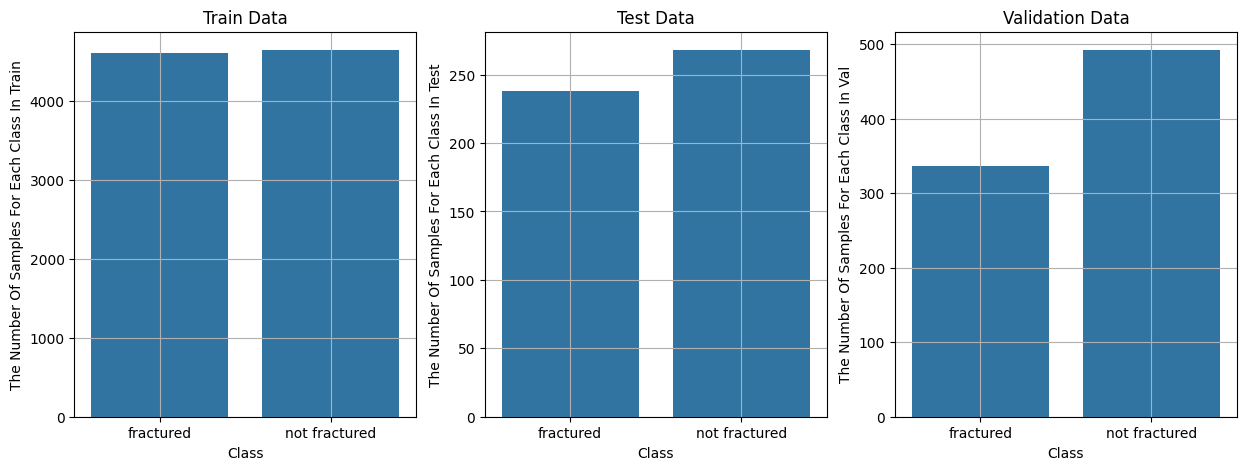

In [11]:
plt.figure(figsize=(15,5))
# Train
plt.subplot(1,3,1)
ax = sns.countplot(x=train.label)
ax.set_xlabel("Class")
ax.set_ylabel("The Number Of Samples For Each Class In Train")
plt.title('Train Data')
plt.grid(True)

# Test
plt.subplot(1,3,2)
ax = sns.countplot(x=test.label)
ax.set_xlabel("Class")
ax.set_ylabel("The Number Of Samples For Each Class In Test")
plt.title('Test Data')
plt.grid(True)

# Val
plt.subplot(1,3,3)
ax = sns.countplot(x=val.label)
ax.set_xlabel("Class")
ax.set_ylabel("The Number Of Samples For Each Class In Val")
plt.title('Validation Data')
plt.grid(True)

plt.show()

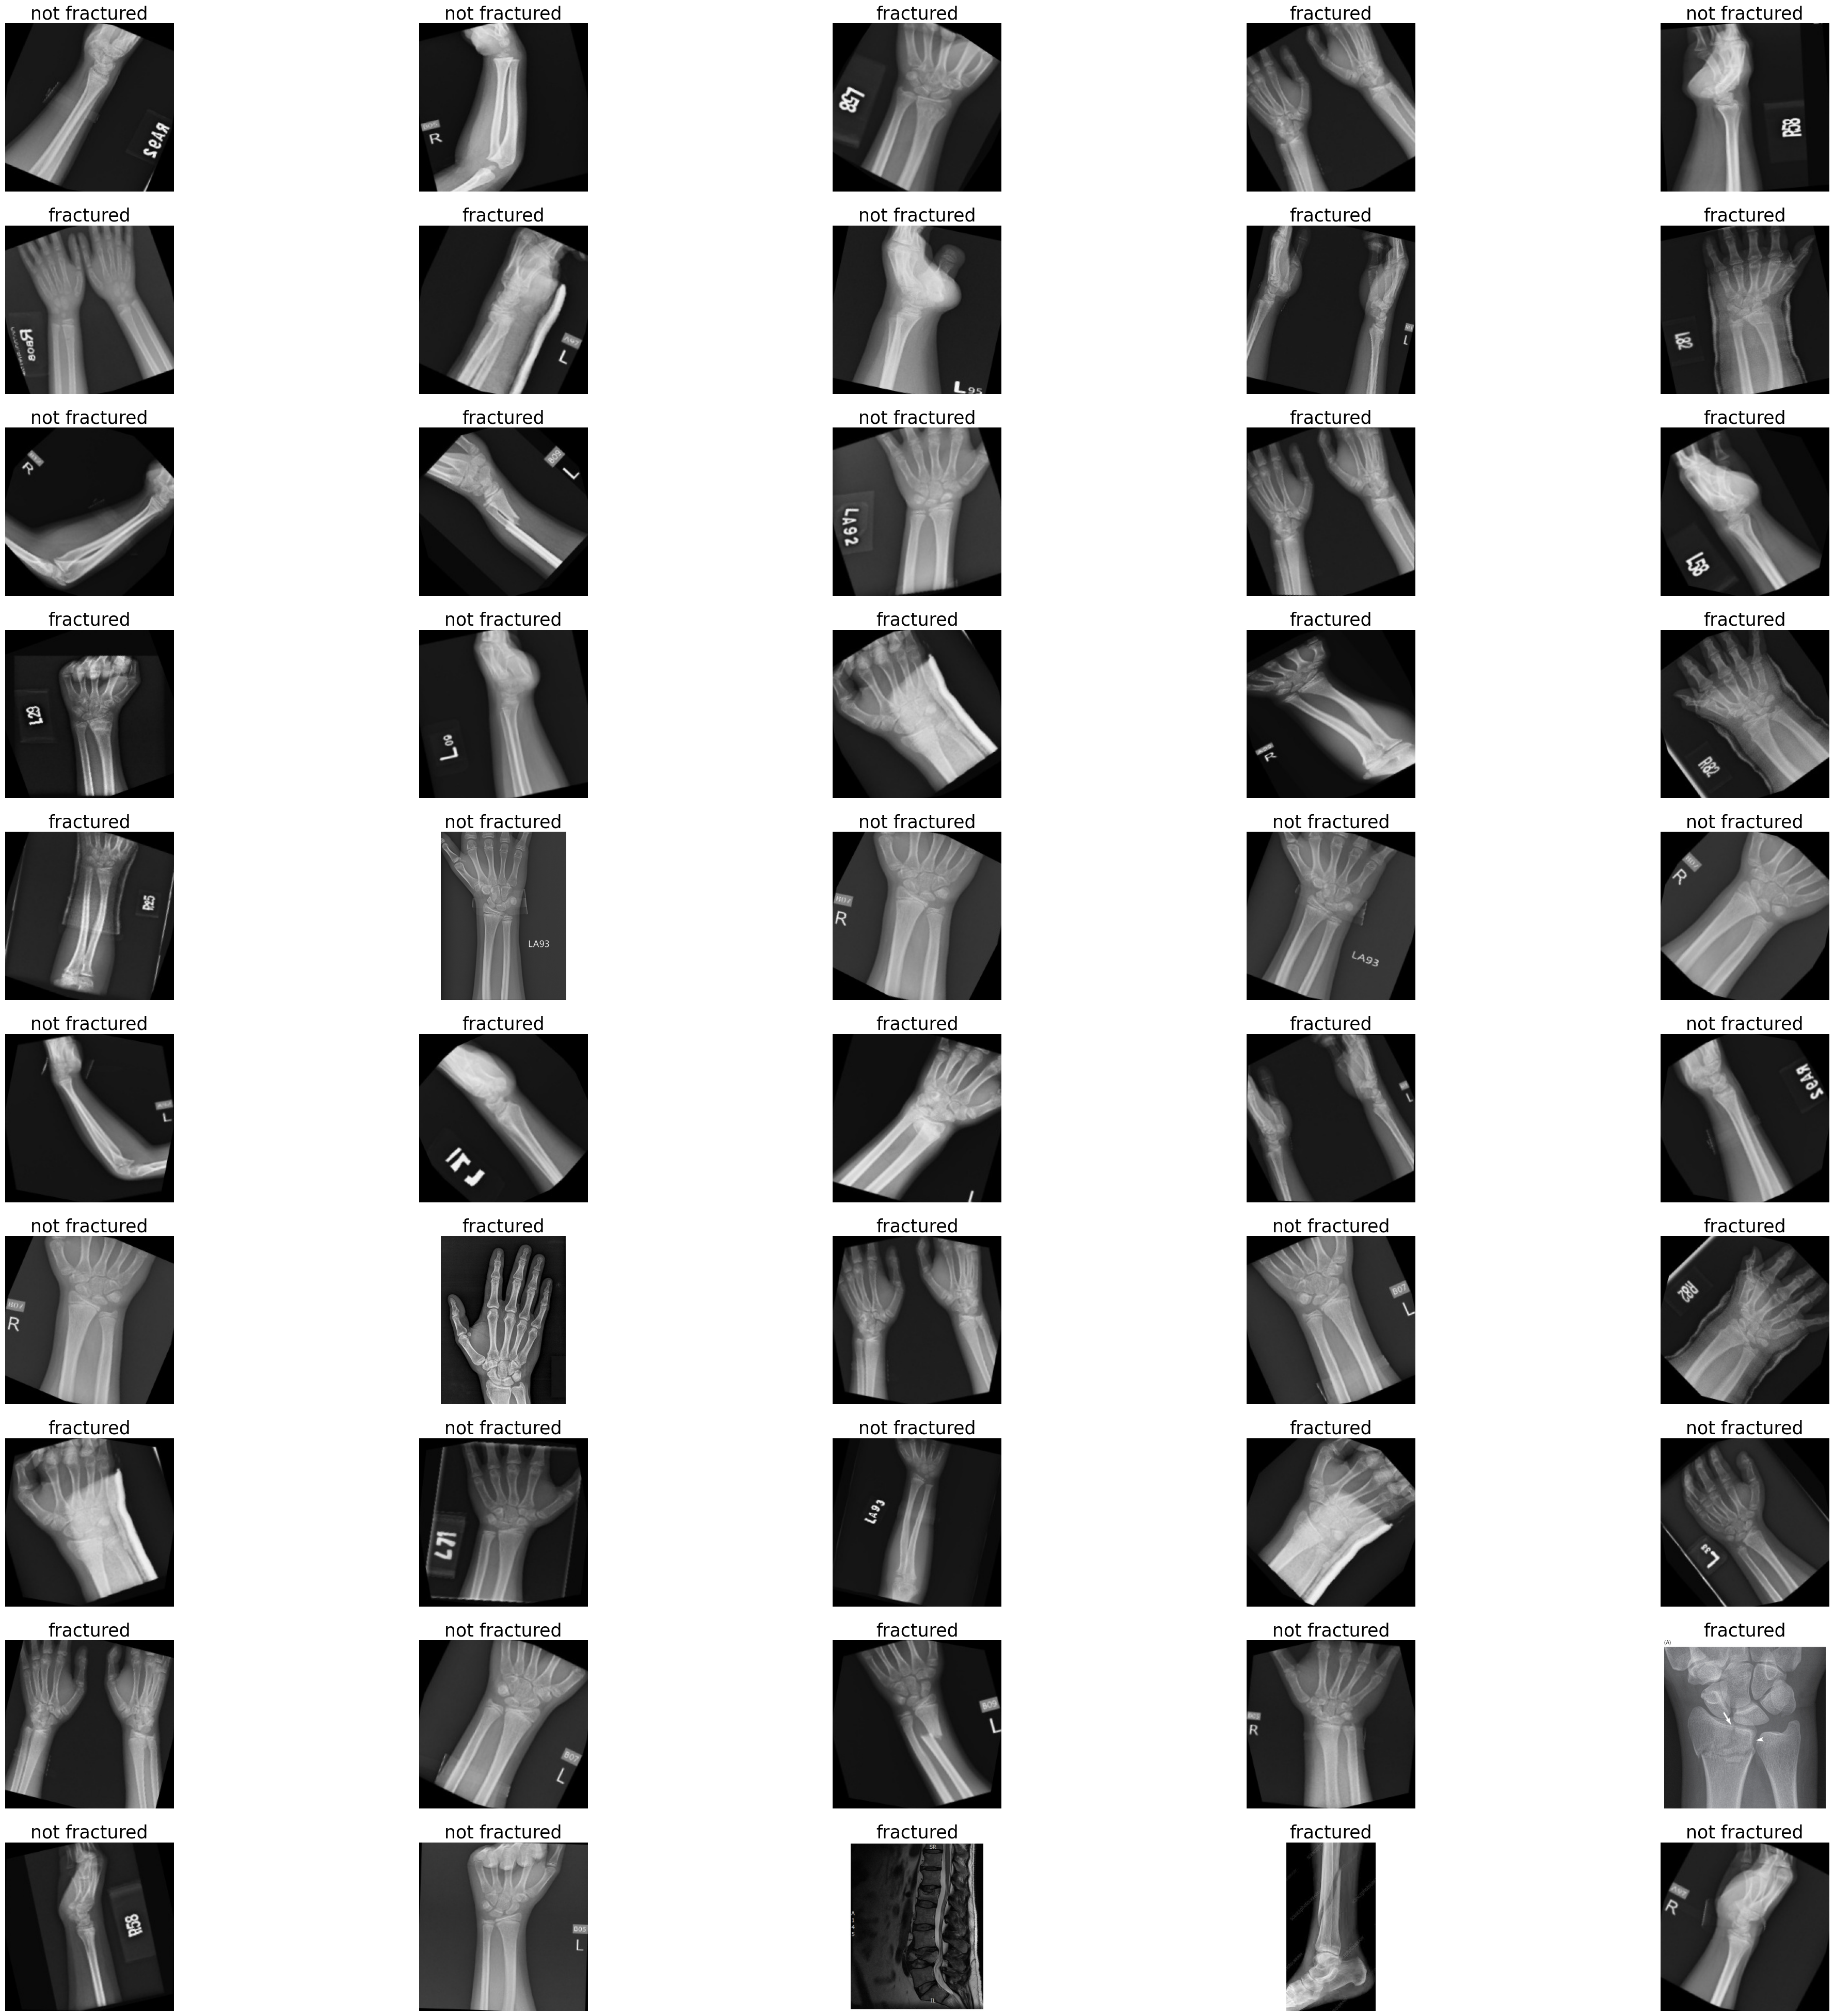

In [12]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(train),50)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(train.image[i])
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(train.label[i],fontsize=25)

# Data Augmentation

In [13]:
import PIL.ImageFile
PIL.ImageFile.LOAD_TRUNCATED_IMAGES = True

image_size = (224, 224)
batch_size = 32

train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_aug = ImageDataGenerator(rescale=1./255)
test_aug = ImageDataGenerator(rescale=1./255)

train_generator = train_aug.flow_from_dataframe(
    train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

val_generator = val_aug.flow_from_dataframe(
    val,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

test_generator = test_aug.flow_from_dataframe(
    test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 9246 validated image filenames belonging to 2 classes.
Found 829 validated image filenames belonging to 2 classes.
Found 506 validated image filenames belonging to 2 classes.


# Model: DENSENET121 TRANSFER LEARNING

In [14]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

base = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

x = GlobalAveragePooling2D()(base.output)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base.input, outputs=output)

base.trainable = False

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [16]:
callbacks = [
    ModelCheckpoint("/content/drive/MyDrive/Models/pretrained_model.h5", save_best_only=True, monitor="val_loss"),
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3)
]

# Train Model

In [17]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/20
289/289 [==============================] - ETA: 0s - loss: 0.5819 - accuracy: 0.6911 - auc: 0.7580

c:\Users\USMAN\tf_gpu\lib\site-packages\PIL\Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


289/289 [==============================] - 114s 364ms/step - loss: 0.5819 - accuracy: 0.6911 - auc: 0.7580 - val_loss: 0.4332 - val_accuracy: 0.8263 - val_auc: 0.9047 - lr: 0.0010
Epoch 2/20
289/289 [==============================] - 100s 346ms/step - loss: 0.4700 - accuracy: 0.7774 - auc: 0.8592 - val_loss: 0.3804 - val_accuracy: 0.8492 - val_auc: 0.9293 - lr: 0.0010
Epoch 3/20
289/289 [==============================] - 100s 345ms/step - loss: 0.4336 - accuracy: 0.8049 - auc: 0.8826 - val_loss: 0.3501 - val_accuracy: 0.8613 - val_auc: 0.9339 - lr: 0.0010
Epoch 4/20
289/289 [==============================] - 101s 349ms/step - loss: 0.4236 - accuracy: 0.8080 - auc: 0.8873 - val_loss: 0.3293 - val_accuracy: 0.8842 - val_auc: 0.9434 - lr: 0.0010
Epoch 5/20
289/289 [==============================] - 100s 343ms/step - loss: 0.4161 - accuracy: 0.8114 - auc: 0.8915 - val_loss: 0.3378 - val_accuracy: 0.8697 - val_auc: 0.9451 - lr: 0.0010
Epoch 6/20
289/289 [==============================] - 10

In [34]:
hist_=pd.DataFrame(history.history)
hist_

loss  accuracy       auc  val_loss  val_accuracy   val_auc      lr
0   0.581864  0.691110  0.758007  0.433181      0.826297  0.904740  0.0010
1   0.470035  0.777417  0.859158  0.380384      0.849216  0.929278  0.0010
2   0.433630  0.804889  0.882567  0.350142      0.861279  0.933934  0.0010
3   0.423635  0.808025  0.887337  0.329336      0.884198  0.943433  0.0010
4   0.416078  0.811378  0.891492  0.337803      0.869723  0.945086  0.0010
5   0.409081  0.811919  0.894734  0.316272      0.875754  0.947679  0.0010
6   0.410762  0.811810  0.893569  0.315821      0.886610  0.948671  0.0010
7   0.407808  0.817435  0.895360  0.309115      0.884198  0.952984  0.0010
8   0.396652  0.821112  0.901776  0.301544      0.880579  0.952344  0.0010
9   0.402796  0.815920  0.897891  0.300390      0.885404  0.950200  0.0010
10  0.405020  0.816786  0.896487  0.302067      0.889023  0.954540  0.0010
11  0.391645  0.820787  0.903632  0.302023      0.874548  0.952203  0.0010
12  0.398124  0.817435  0.899822  0.312595      0.860072  0.953174  0.0010
13  0.388690  0.824573  0.905065  0.294425      0.895054  0.954775  0.0002
14  0.388899  0.826844  0.904929  0.293267      0.896261  0.954407  0.0002
15  0.379112  0.831170  0.910678  0.299404      0.893848  0.953771  0.0002
16  0.392607  0.818408  0.902667  0.291012      0.897467  0.954896  0.0002
17  0.387851  0.827385  0.906144  0.289934      0.895054  0.955405  0.0002
18  0.389923  0.823167  0.904213  0.290449      0.897467  0.955547  0.0002
19  0.391488  0.821436  0.903679  0.289720      0.899879  0.955677  0.0002

In [23]:
for layer in base.layers[:-40]:
    layer.trainable = False


In [24]:
# base.trainable = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

In [25]:
history_ft = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
289/289 [==============================] - 128s 419ms/step - loss: 0.7604 - accuracy: 0.7289 - auc_4: 0.8622 - val_loss: 0.3158 - val_accuracy: 0.8577 - val_auc_4: 0.9666 - lr: 1.0000e-05
Epoch 2/10
289/289 [==============================] - 116s 402ms/step - loss: 0.5086 - accuracy: 0.8058 - auc_4: 0.8994 - val_loss: 0.2210 - val_accuracy: 0.9131 - val_auc_4: 0.9741 - lr: 1.0000e-05
Epoch 3/10
289/289 [==============================] - 119s 411ms/step - loss: 0.4004 - accuracy: 0.8483 - auc_4: 0.9244 - val_loss: 0.1826 - val_accuracy: 0.9324 - val_auc_4: 0.9798 - lr: 1.0000e-05
Epoch 4/10
289/289 [==============================] - 119s 411ms/step - loss: 0.3400 - accuracy: 0.8666 - auc_4: 0.9407 - val_loss: 0.1630 - val_accuracy: 0.9421 - val_auc_4: 0.9832 - lr: 1.0000e-05
Epoch 5/10
289/289 [==============================] - 117s 405ms/step - loss: 0.3069 - accuracy: 0.8744 - auc_4: 0.9500 - val_loss: 0.1474 - val_accuracy: 0.9505 - val_auc_4: 0.9855 - lr: 1.0000e-05
Epoch

In [26]:
hist_=pd.DataFrame(history_ft.history)
hist_

loss  accuracy     auc_4  val_loss  val_accuracy  val_auc_4       lr
0  0.760402  0.728856  0.862222  0.315797      0.857660   0.966629  0.00001
1  0.508563  0.805754  0.899391  0.221038      0.913148   0.974138  0.00001
2  0.400357  0.848259  0.924401  0.182592      0.932449   0.979774  0.00001
3  0.339968  0.866645  0.940707  0.163041      0.942099   0.983182  0.00001
4  0.306919  0.874432  0.950000  0.147383      0.950543   0.985534  0.00001
5  0.257682  0.896820  0.962756  0.134472      0.955368   0.987401  0.00001
6  0.234487  0.909366  0.968498  0.121681      0.958987   0.989228  0.00001
7  0.195776  0.924292  0.976912  0.113731      0.963812   0.990371  0.00001
8  0.177801  0.927753  0.981205  0.107482      0.965018   0.990323  0.00001
9  0.155563  0.938676  0.985070  0.101936      0.967431   0.990190  0.00001

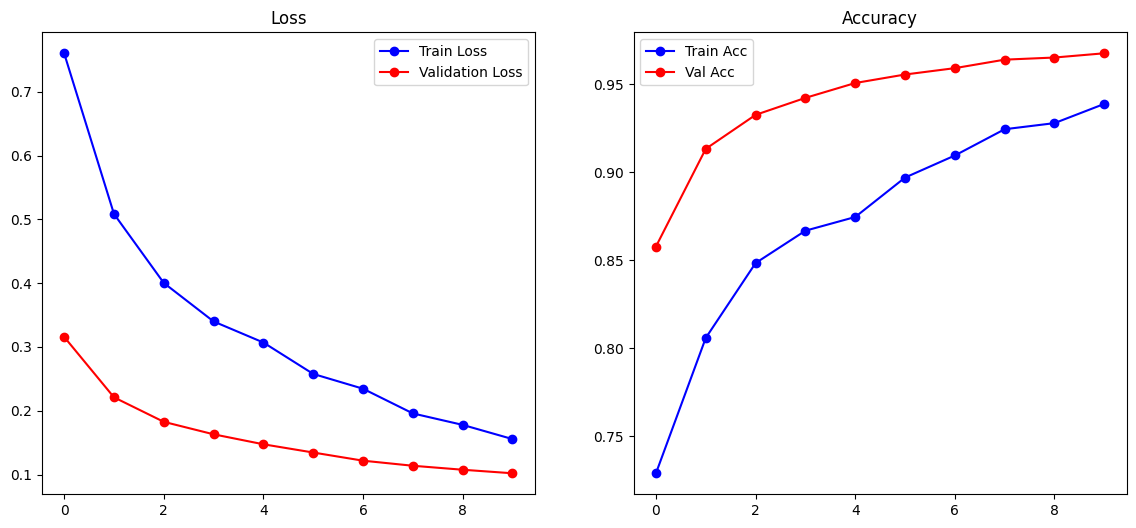

In [27]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],'b-o',label='Train Loss')
plt.plot(hist_['val_loss'],'r-o',label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],'b-o',label='Train Acc')
plt.plot(hist_['val_accuracy'],'r-o',label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.show()

In [28]:
score, acc, auc = model.evaluate(test_generator)
print('Test Loss =', score)
print('Test Accuracy =', acc)
print('Test AUC =', auc)

16/16 [==============================] - 10s 581ms/step - loss: 0.1198 - accuracy: 0.9565 - auc_4: 0.9906
Test Loss = 0.11976248025894165
Test Accuracy = 0.95652174949646
Test AUC = 0.9906089305877686


In [29]:
y_test =test_generator.classes
predictions = model.predict(test_generator)
y_pred = np.where(predictions >= 0.5, 1, 0)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})
df

16/16 [==============================] - 7s 333ms/step


Actual  Prediction
0         0           0
1         0           1
2         0           0
3         0           0
4         0           0
..      ...         ...
501       1           1
502       1           1
503       1           1
504       1           0
505       1           0

[506 rows x 2 columns]

In [30]:
y_true = test_generator.classes
pred = model.predict(test_generator)
y_pred = (pred > 0.5).astype(int).ravel()

16/16 [==============================] - 5s 338ms/step


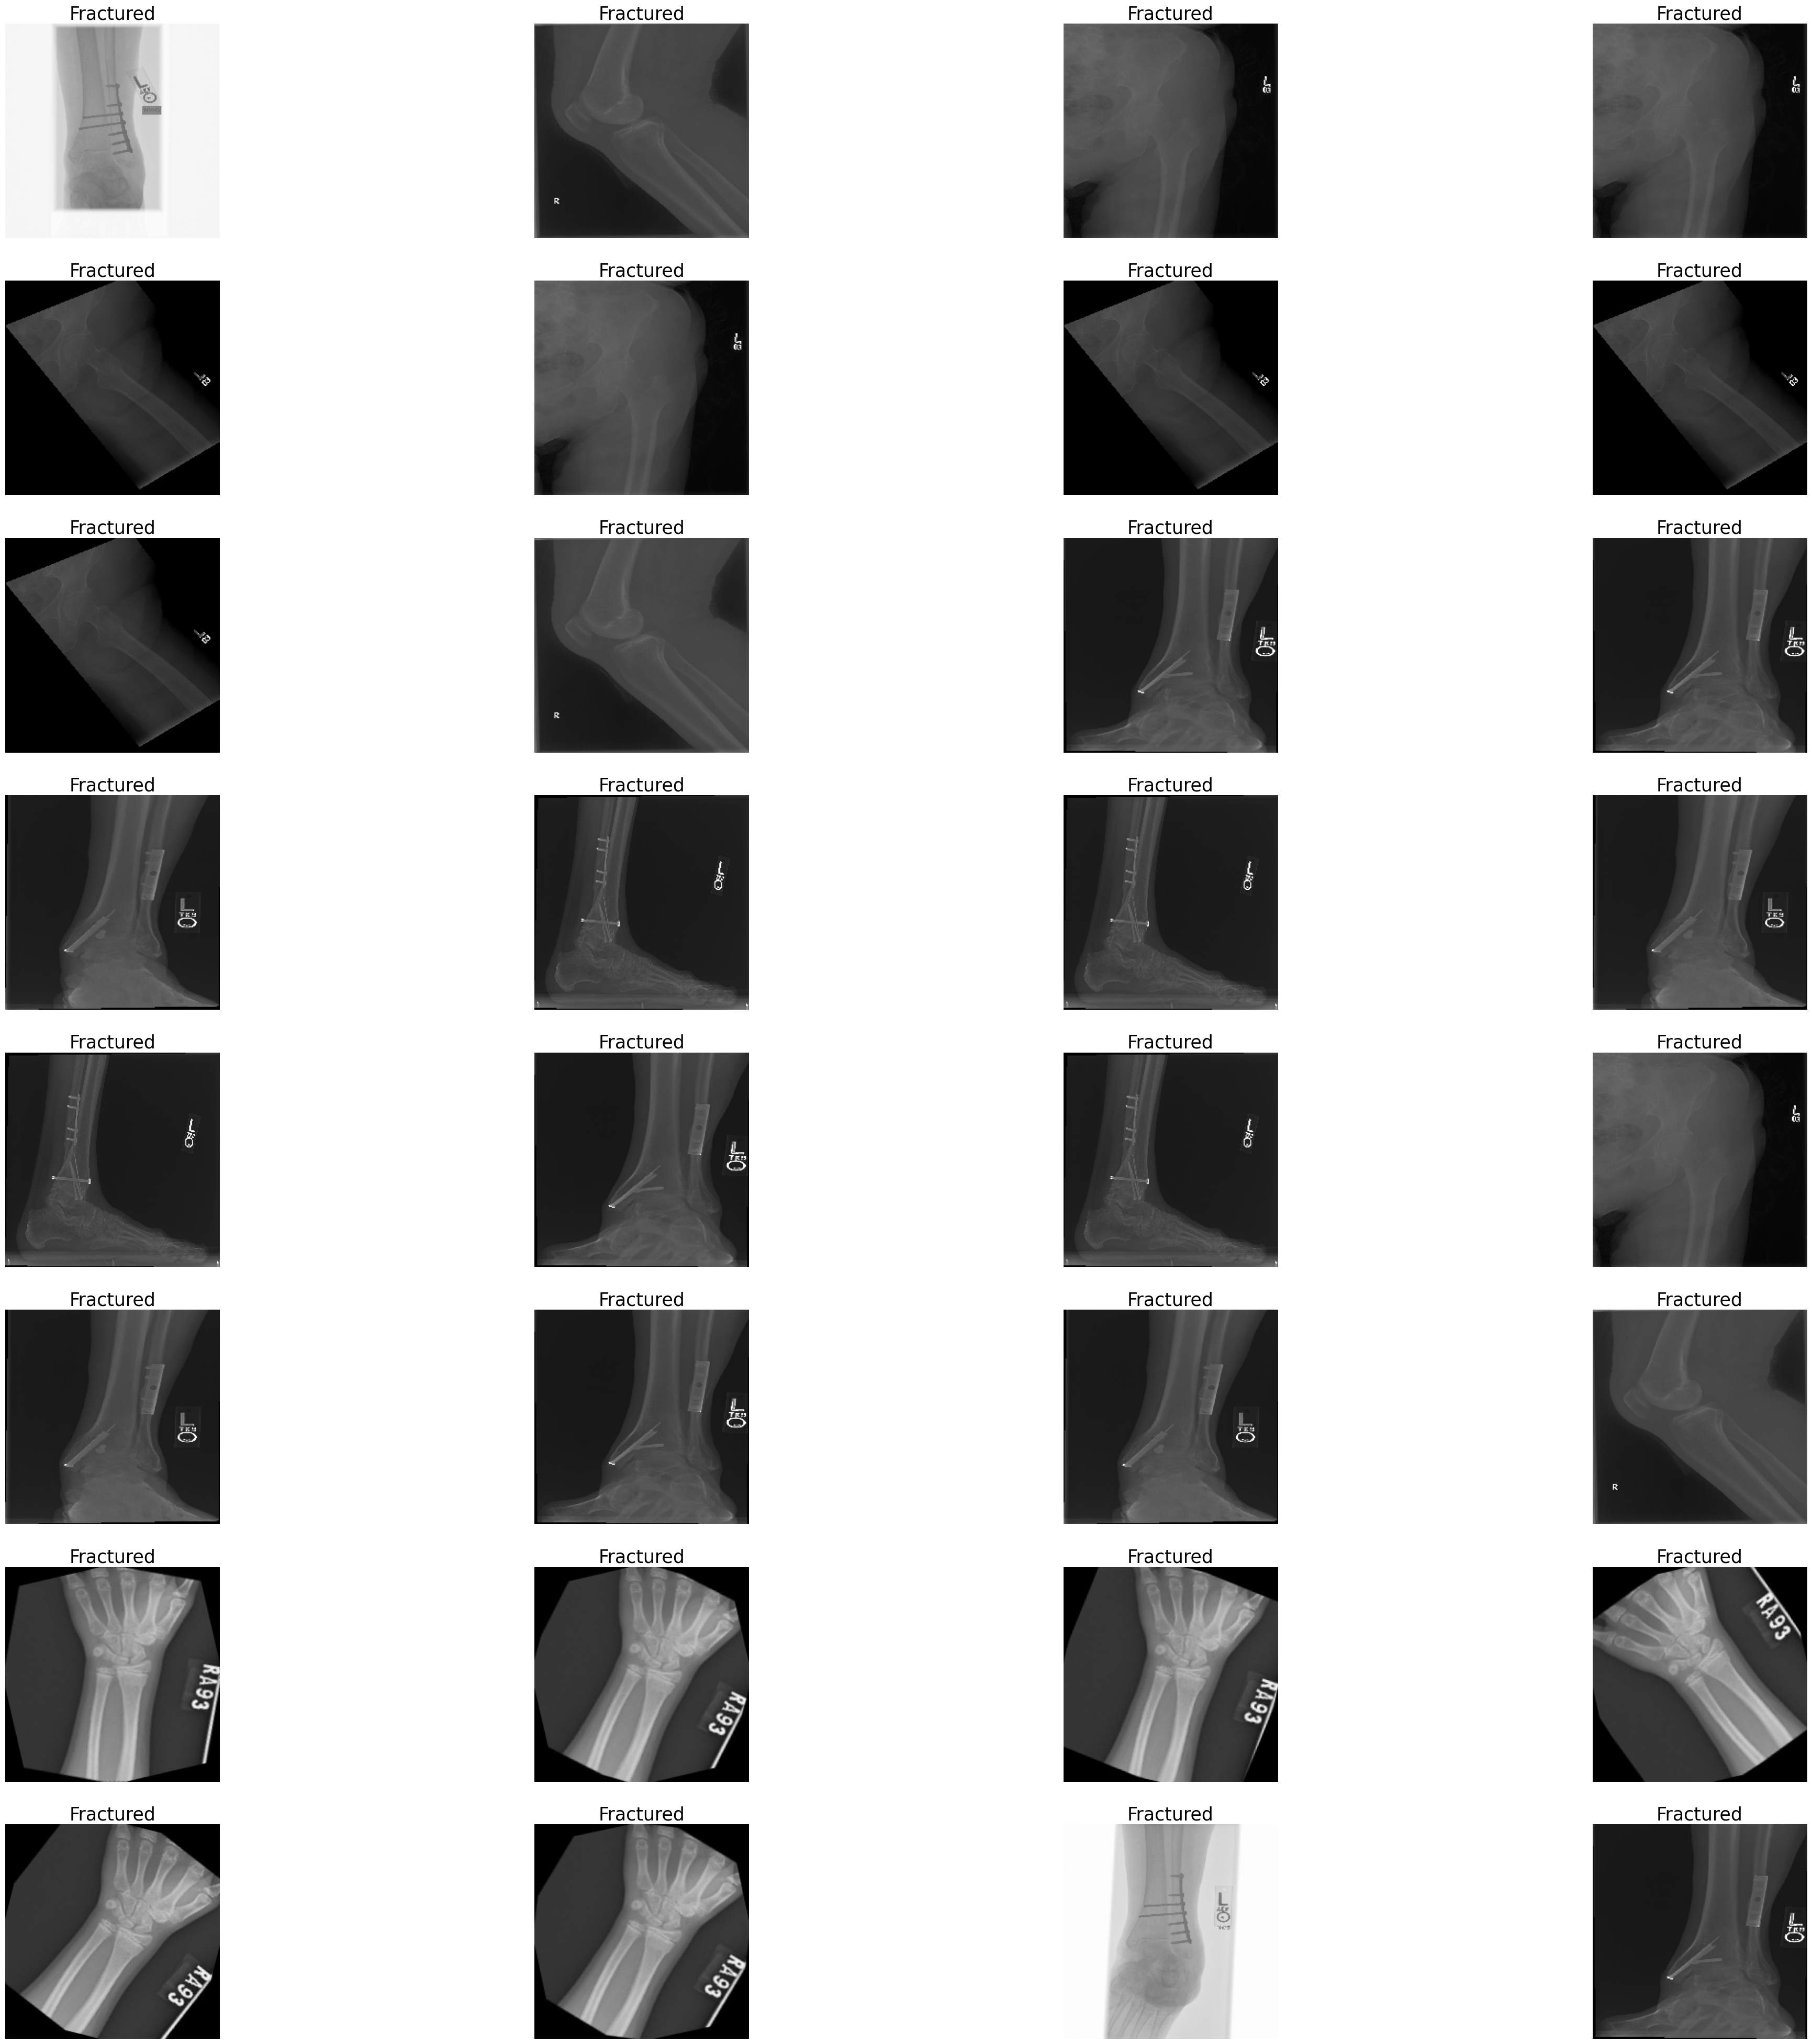

In [31]:
class_names=['Fractured', 'Not Fractured']
batch = next(test_generator)
images= batch[0]
plt.figure(figsize=(50,50))
for n in range(32):
    plt.subplot(8,4,n+1)
    plt.imshow(images[n])
    plt.axis('off')
    plt.title(class_names[int(y_test[n])],fontsize=25)

array([[225,  13],
       [  9, 259]], dtype=int64)

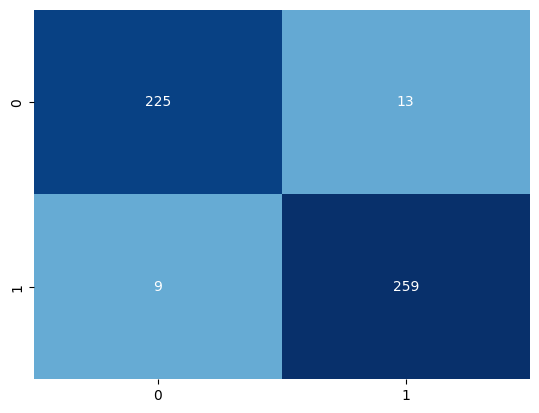

In [32]:
CM = confusion_matrix(y_test,y_pred)
sns.heatmap(CM,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

# Results

In [33]:
ClassificationReport = classification_report(y_test,y_pred)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.96      0.95      0.95       238
           1       0.95      0.97      0.96       268

    accuracy                           0.96       506
   macro avg       0.96      0.96      0.96       506
weighted avg       0.96      0.96      0.96       506



In [37]:
print(train_generator.class_indices)

{'fractured': 0, 'not fractured': 1}


In [36]:
model.save("C:/Users/USMAN/Desktop/FYP/Bone Fracture/Bone_Fracture_Model.h5")